In [1]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from yahoo_fin import stock_info as si
import datetime as dt
from pyspark.ml import Pipeline
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month, dayofmonth, concat, lit, lpad, col, collect_list
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import unix_timestamp

from pyspark.sql.window import Window
import pyspark.pandas as ps

/Users/matteopancini/opt/anaconda3/envs/notensor/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Data Collection

In [2]:
ticker = 'TSLA'
start_date = dt.datetime(2013, 9, 30)
end_date = dt.datetime(2023, 1, 1)
fred_symbols = ['SP500', 'DJIA', 'NASDAQCOM', 'VIXCLS', 'GVZCLS', 'DTWEXBGS', 'IUDSOIA', 'BAMLHE00EHYIEY', 'DFF', 'T10Y2Y', 'DGS10', 'T10YIE', 'T5YIE', 'DTB3']

In [3]:
historical_data = si.get_data(ticker, start_date, end_date, interval='1d')
fred_df = pdr.get_data_fred(fred_symbols, start_date, end_date)

# Data Pre-Processing with Spark

In [4]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 15:01:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
historical_data_spark = spark.createDataFrame(historical_data.reset_index())
fred_df_spark = spark.createDataFrame(fred_df.reset_index())

In [6]:
historical_data_spark = historical_data_spark.withColumnRenamed("index", "DATE")
historical_data_spark = historical_data_spark.drop('ticker', 'adjclose')

historical_data_spark = historical_data_spark.withColumn("year", year("DATE"))
historical_data_spark = historical_data_spark.withColumn("month", month("DATE"))
historical_data_spark = historical_data_spark.withColumn("day", dayofmonth("DATE"))
historical_data_spark = historical_data_spark.withColumn('fulldate', concat(historical_data_spark['year'],
                                       lpad(historical_data_spark['month'], 2, '0'),
                                       lpad(historical_data_spark['day'], 2, '0')))
historical_data_spark = historical_data_spark.withColumn('fulldate', historical_data_spark['fulldate'].cast('int'))

In [7]:
fred_df_spark = fred_df_spark.withColumn("Index", monotonically_increasing_id())
#fred_df_spark.show()

In [8]:
dataset_spark = historical_data_spark.join(fred_df_spark, on="DATE", how="left")
dataset_spark = dataset_spark.orderBy("DATE")
dataset_spark = dataset_spark.withColumn("Index", monotonically_increasing_id())
#dataset_spark.show()

In [9]:
# Use Spark SQL to get some basic statistics and print the results
dataset_spark.createOrReplaceTempView("dataset_spark")
spark.sql("SELECT COUNT(*) FROM dataset_spark").show()
spark.sql("SELECT COUNT(*) FROM dataset_spark WHERE close IS NULL").show()
spark.sql("SELECT COUNT(*) FROM dataset_spark WHERE SP500 IS NULL").show()
spark.sql("SELECT COUNT(*) FROM dataset_spark WHERE DJIA IS NULL").show()
spark.sql("SELECT COUNT(*) FROM dataset_spark WHERE NASDAQCOM IS NULL").show()

print("Number of rows in the DataFrame: ", dataset_spark.count())

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=17359Kb max_used=17359Kb free=113712Kb
 bounds [0x0000000103fd4000, 0x00000001050e4000, 0x000000010bfd4000]
 total_blobs=7335 nmethods=6488 adapters=757
 compilation: disabled (not enough contiguous free space left)


+--------+
|count(1)|
+--------+
|    2331|
+--------+
+--------+
|count(1)|
+--------+
|       0|
+--------+
+--------+
|count(1)|
+--------+
|       0|
+--------+
+--------+
|count(1)|
+--------+
|       0|
+--------+
+--------+
|count(1)|
+--------+
|       0|
+--------+
Number of rows in the DataFrame:  2331


+-----------------+-----------------+-----------------+------------------+
|        min_close|        max_close|       mean_close|      stddev_close|
+-----------------+-----------------+-----------------+------------------+
|8.033332824707031|409.9700012207031|78.50024281955491|104.10943561376506|
+-----------------+-----------------+-----------------+------------------+


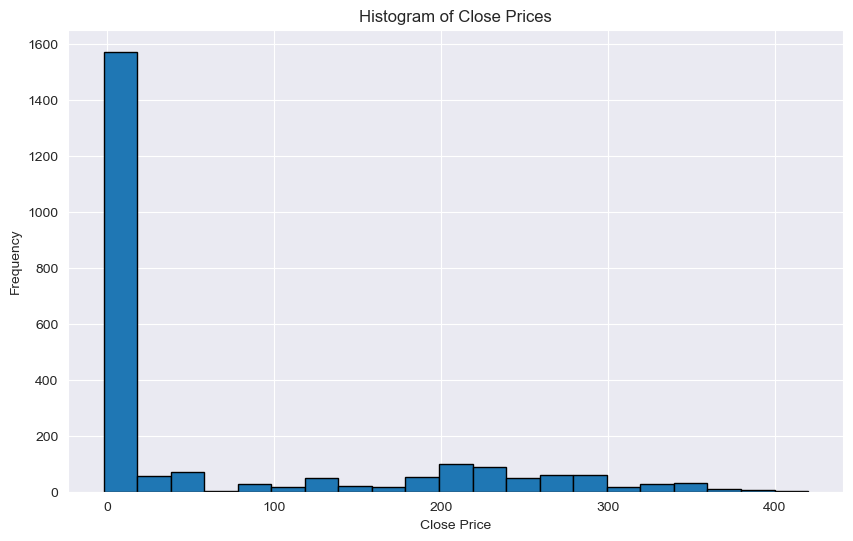

In [10]:
# Calculate summary statistics for the "close" column
summary_query = "SELECT MIN(close) AS min_close, MAX(close) AS max_close, AVG(close) AS mean_close, STDDEV(close) AS stddev_close FROM dataset_spark"
summary_result = spark.sql(summary_query)
summary_result.show()

# Define the number of bins for the histogram
num_bins = 20

# Calculate bin width
bin_width = (summary_result.collect()[0]["max_close"] - summary_result.collect()[0]["min_close"]) / num_bins

# Generate the histogram data
histogram_query = f"SELECT CAST((close - {summary_result.collect()[0]['min_close']}) / {bin_width} AS INT) AS bin, COUNT(*) AS frequency FROM dataset_spark GROUP BY bin ORDER BY bin"
histogram_data = spark.sql(histogram_query)

# Collect the histogram data to the driver
histogram_data_df = histogram_data.toPandas()

# Plot the histogram using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(histogram_data_df["bin"] * bin_width + summary_result.collect()[0]["min_close"], histogram_data_df["frequency"], width=bin_width, edgecolor='k')
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.title("Histogram of Close Prices")
plt.show()

In [10]:
#dataset_spark = dataset_spark.drop("fulldate")

In [11]:
# Drop rows where 'column1' or 'column2' have null values
dataset_spark = dataset_spark.dropna()
dataset_spark.show()

+-------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+--------+-------+--------+---------+------+------+--------+-------+--------------+----+------+-----+------+-----+----+-----+
|               DATE|              open|              high|               low|             close|   volume|year|month|day|fulldate|  SP500|    DJIA|NASDAQCOM|VIXCLS|GVZCLS|DTWEXBGS|IUDSOIA|BAMLHE00EHYIEY| DFF|T10Y2Y|DGS10|T10YIE|T5YIE|DTB3|Index|
+-------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+--------+-------+--------+---------+------+------+--------+-------+--------------+----+------+-----+------+-----+----+-----+
|2013-09-30 00:00:00|12.600000381469727|12.966667175292969|12.533332824707031|12.891332626342773|133870500|2013|    9| 30|20130930|1681.55|15129.67|  3771.48|  16.6| 23.72| 92.9207|  0.411|           5.5|0.06|  2.31| 2.64|  2.19| 1.74|0.02|    0|
|2013-10-01 

In [12]:
# Assuming 'df' is your Spark DataFrame
row_count = dataset_spark.count()

# Print the row count
print("Number of rows in the DataFrame: ", row_count)

Number of rows in the DataFrame:  2248


In [13]:
# Save into an array the DATE column
dates = dataset_spark.select("DATE").collect()
# Dates to convert into pandas array
dates = [date[0] for date in dates]
dataset_spark_training = dataset_spark.drop("DATE")

In [27]:
# Save into an array the close column
all_closes = dataset_spark.select("close").collect()

# MLLib

In [14]:
# Prepare data for MLlib
feature_columns = [col_name for col_name in dataset_spark_training.columns if col_name != 'close']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# Determine the split point based on the desired ratio
split_ratio = 0.8  # 80% for training, 20% for testing
split_point = int(dataset_spark_training.count() * split_ratio)

# Split the data into training and testing sets
train_data = dataset_spark_training.limit(split_point)
test_data = dataset_spark_training.subtract(train_data)

# Reorder by index
train_data = train_data.orderBy("Index")
test_data = test_data.orderBy("Index")

In [15]:
# Count the number of rows in each DataFrame
print("Number of rows in the training data set: ", train_data.count())
print("Number of rows in the testing data set: ", test_data.count())

Number of rows in the training data set:  1798
Number of rows in the testing data set:  450


# Linear Regression

In [16]:
lr = LinearRegression(labelCol='close', featuresCol='features')

In [17]:
pipeline = Pipeline(stages=[vector_assembler, lr])

In [18]:
# Linear Regression in Spark
lr_model = pipeline.fit(train_data)

23/10/02 14:42:04 WARN Instrumentation: [e7a30c48] regParam is zero, which might cause numerical instability and overfitting.
23/10/02 14:42:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/02 14:42:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [19]:
# Model Evaluation in Spark
lr_predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

In [20]:
lr_rmse = evaluator.evaluate(lr_predictions)
lr_rmse

4.020249073297718

In [21]:
# Convert lr_predictions DataFrame to Pandas DataFrame
predictions_pd = lr_predictions.select("Index", "close", "prediction").toPandas()

# Extract the actual "close" values and timestamp
actual_close = predictions_pd["close"]
#dates = predictions_pd["Index"]

# Extract the predicted values
predicted_close = predictions_pd["prediction"]

In [29]:
# Take just last 20% of dates (the testing set)
dates_test = dates[split_point:]

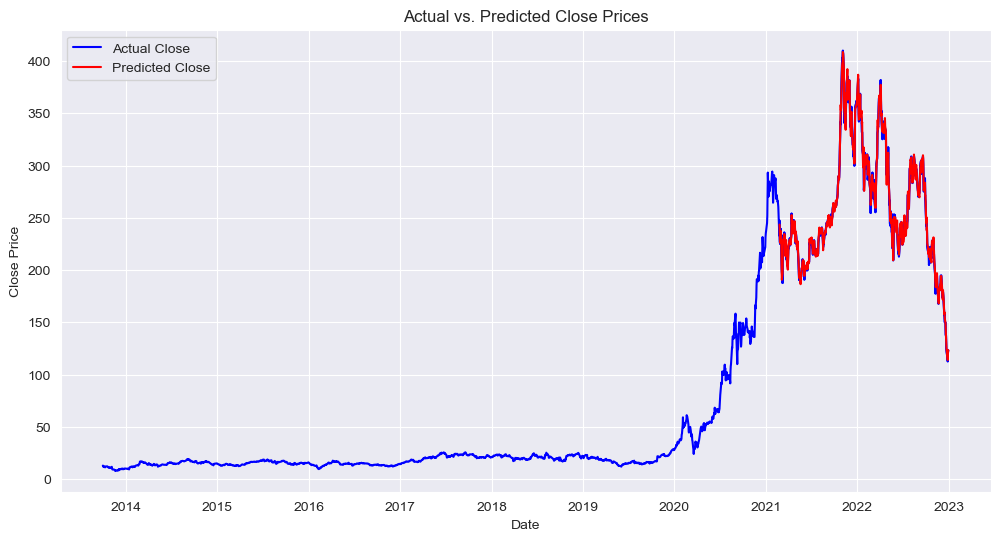

In [31]:
# Create a time series plot also with all training data
plt.figure(figsize=(12, 6))
plt.plot(dates, all_closes, color="b")
plt.plot(dates_test, actual_close, label="Actual Close", color="b")
plt.plot(dates_test, predicted_close, label="Predicted Close", color="r")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
def predict_future_close_prices(model_fit, future_timestamps):
    # Create a DataFrame for future timestamps
    future_data = pd.DataFrame({'fulldate': future_timestamps}).astype({'fulldate': 'int'})

    # Create a Spark DataFrame from the Pandas DataFrame
    future_data_spark = spark.createDataFrame(future_data)

    # Use the vector assembler to assemble features
    future_data_spark = vector_assembler.transform(future_data_spark)

    # Make predictions for future timestamps
    future_predictions = model_fit.transform(future_data_spark)

    # Extract the predicted close prices
    future_predicted_close = future_predictions.select("prediction").rdd.map(lambda row: row[0]).collect()

    return future_predicted_close


In [33]:
days_into_future = 10


In [37]:
# Take last date available in dates
last_date = dates[-1]
last_date

datetime.datetime(2022, 12, 30, 0, 0)

In [40]:
# Create a list of future timestamps
future_timestamps = pd.date_range(last_date, periods=days_into_future + 1, freq='D')

In [41]:
# Call the predict_future_close_prices function
future_predicted_close = predict_future_close_prices(lr_model, future_timestamps)

# Create a DataFrame for the future predictions
future_predictions_df = pd.DataFrame({'fulldate': future_timestamps, 'predicted_close': future_predicted_close})

IllegalArgumentException: open does not exist. Available: fulldate